In [1]:
import numpy as np
import matplotlib.pyplot as plt
address = 'eq_cluster_further_until7_EFfix'
Ru_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Ru.npz', allow_pickle=True)
train_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_train.npz', allow_pickle=True)
validate_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_validate.npz', allow_pickle=True)
test_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_test.npz', allow_pickle=True)

In [2]:
from cp2k_reader import Cp2kTrajHold, gather_all_data
from cp2k_reader import building_of_one_metal_traj, building_of_one_metal_special
from ocp.ocpmodels.datasets import SinglePointLmdbDataset

/Users/shaoketong/anaconda3/envs/new-ocp-models/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test_true  = SinglePointLmdbDataset({"src": 'data/Pt_cluster_all_test/Pt_cluster_all_test.lmdb'})
validate_true  = SinglePointLmdbDataset({"src": 'data/Pt_cluster_all_validate/Pt_cluster_all_validate.lmdb'})
train_true  = SinglePointLmdbDataset({"src": 'data/Pt_cluster_all_train/Pt_cluster_all_train.lmdb'})
Ru_cluster  = SinglePointLmdbDataset({"src": 'data/Ru_cluster_all/Ru_cluster_all.lmdb'})


/Users/shaoketong/anaconda3/envs/new-ocp-models/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3548: UserWarning: SinglePointLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import numpy as np
Ru_prediction_list = []
train_prediction_list = []
validate_prediction_list = []
test_prediction_list = []
names = ['eq_cluster_direct_until5', 'eq_cluster_further_until5', 'eq_cluster_mix_until5']
for address in names:
    Ru_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Ru.npz', allow_pickle=True))
    train_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_train.npz', allow_pickle=True))
    validate_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_validate.npz', allow_pickle=True))
    test_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_test.npz', allow_pickle=True))

# Fine-tuning methods comparion

In [7]:
from sklearn.metrics import r2_score, explained_variance_score

def energy_force_scores(true, pred, metal_number='all', score=r'$R^2$'):
    order = [int(_.split('_')[0]) for _ in pred['ids']]
    reverse_order = [0]*len(order)
    for idx, ord in enumerate(order):
        reverse_order[ord] = idx
    metal_y = [true[_].y for _ in range(len(true))]
    true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
    metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)
    if metal_number == 'all':
        true_metal_force = true_forces[metal_itself != 0, :].reshape(-1)
        pred_metal_force = pred['forces'][metal_itself != 0, :].reshape(-1)
    else:
        true_metal_force = true_forces[metal_itself == metal_number, :].reshape(-1)
        pred_metal_force = pred['forces'][metal_itself == metal_number, :].reshape(-1)
    if score == r'$R^2$':
        ene_score = r2_score(np.array(metal_y), pred['energy'][reverse_order])
        force_score = r2_score(true_metal_force, pred_metal_force)
    elif score == 'MAE':
        ene_score = np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean()
        force_score = np.abs(true_metal_force - pred_metal_force).mean()
    return ene_score, force_score
    

def plot_model_compare(files_list, labels, score=r'$R^2$'):
    plt.rcParams['text.usetex'] = True
    params= {"text.latex.preamble": r"\usepackage{amsmath}"}
    plt.rcParams.update(params)
    fig, axs = plt.subplots(1, 2, dpi=400, figsize=(7,3))
    #axs[0].annotate('', xy=(1, 1), xytext=(0.9987, 0.962), c='red',
    #                arrowprops=dict(facecolor='red', arrowstyle='->'),
    #                xycoords='axes fraction', textcoords='data')

    #axs[1].annotate('', xy=(0, 0), xytext=(1.1, 0.2), c='red',
    #                arrowprops=dict(facecolor='red', arrowstyle='->'),
    #                xycoords='axes fraction', textcoords='data')
    #mycolor = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2',]
    #mycolor = ['#F27970', '#BB9727', '#54B345' , '#32B897', '#05B9E2', '#8983BF', '#C76DA2']
    #mycolor = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E','#CFEAF1','#C4A5DE','#F6CAE5','#96CCCB']
    mycolor = [
                '#aec7e8',  # Light Blue
                '#ffbb78',  # Light Orange
                '#98df8a',  # Light Green
                '#ff9896',  # Light Red
                '#c5b0d5',  # Light Purple
                '#c49c94',  # Light Brown
                '#f7b6d2',  # Light Pink
                '#c7c7c7',  # Light Gray
                '#dbdb8d',  # Light Olive
                '#9edae5',  # Light Cyan
                '#fdd0a2',  # Light Peach
                '#d62728',  # Soft Red
                '#2ca02c',  # Soft Green
                '#7f7f7f',  # Medium Gray
                '#9467bd',  # Soft Purple
                '#8c564b',  # Soft Brown
                '#e377c2',  # Soft Pink
                '#bcbd22',  # Soft Lime
                '#17becf',  # Soft Cyan
                '#9c9ede'   # Lavender
            ]
    subplot_labels = ['(a) Pt cluster test', '(b) Ru cluster', '(c)', '(d)']

    for address, label in zip(files_list, labels):
        Ru_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Ru.npz', allow_pickle=True)
        train_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_train.npz', allow_pickle=True)
        validate_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_validate.npz', allow_pickle=True)
        test_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_test.npz', allow_pickle=True)
        # test energy-force######
        test_score = 'MAE'
        ene_score, force_score = energy_force_scores(test_true, test_prediction, metal_number='all', score=test_score)
        axs[0].scatter(ene_score, force_score, s=16, label=label, color=mycolor[files_list.index(address)])
        # Ru cluster energy-force######
        ene_score, force_score = energy_force_scores(Ru_cluster, Ru_prediction, metal_number=44, score=score)
        axs[1].scatter(ene_score, force_score, s=16, color=mycolor[files_list.index(address)])
        

    axs[0].set(xlabel=f'Energy {test_score}', ylabel=f'Atomic Force {test_score}')
    #axs[0].legend(ncol=2, frameon=False, loc='lower right', prop={'size': 6})
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=6, frameon=False)
    axs[1].set(xlabel=f'Energy {score}', ylabel=f'Ru Atomic Force {score}')
    
    if score == r'$R^2$':
        axs[0].set_xlim([0.,1.05])
        axs[0].set_ylim([0.,1.05])
        axs[1].set_xlim([0.,1.05])
        axs[1].set_ylim([0.,1.05])
    #axs[0,1].legend(frameon=False, loc='lower right', prop={'size': 6})
    #axs[1,0].legend(frameon=False, loc='lower right', prop={'size': 6})
    #axs[1,1].legend(frameon=False, loc='lower right', prop={'size': 6})
    # Loop through all subplots and annotate them
    
    for ax_idx, ax in enumerate(axs.flat):
        # Place the annotation in the top-left corner of the subplot
        ax.text(0.02, 0.98, subplot_labels[ax_idx], transform=ax.transAxes, fontsize=12,
            verticalalignment='top')
    plt.tight_layout()
    plt.show()


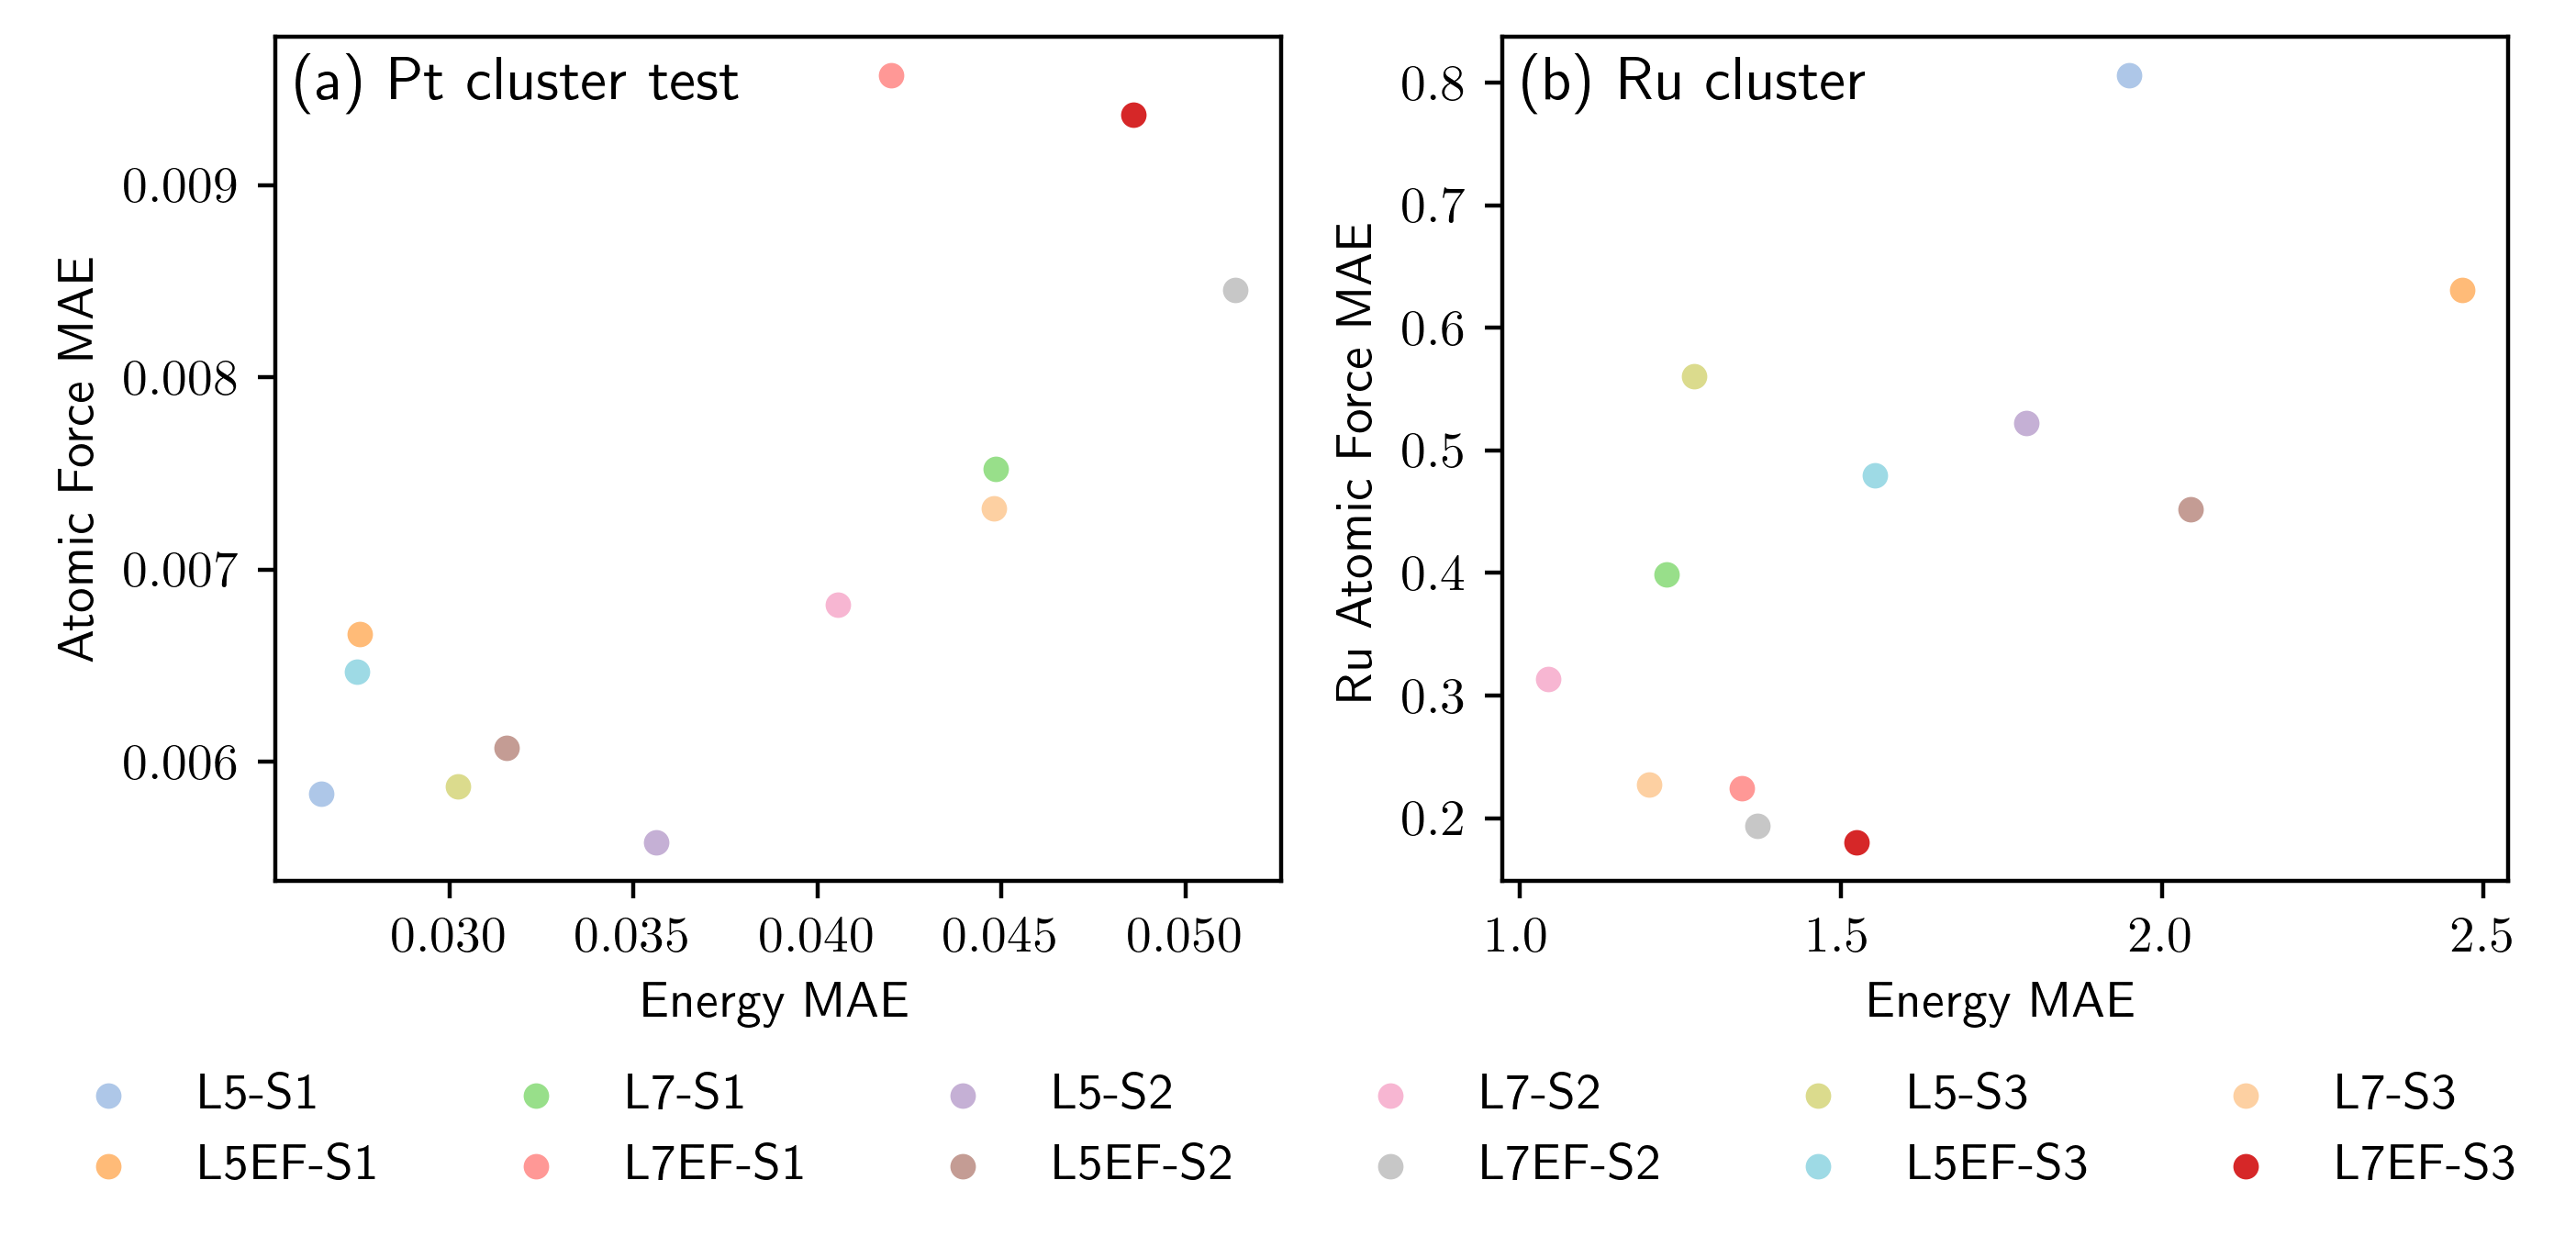

In [8]:
exps = ['eq_cluster_direct_until5', 
        'eq_cluster_direct_until5_EFfix', 
        'eq_cluster_direct_until7', 
        'eq_cluster_direct_until7_EFfix', 
        'eq_cluster_further_until5', 
        'eq_cluster_further_until5_EFfix', 
        'eq_cluster_further_until7', 
        'eq_cluster_further_until7_EFfix',  
        'eq_cluster_mix_until5', 
        'eq_cluster_mix_until5_EFfix', 
        'eq_cluster_mix_until7', 
        'eq_cluster_mix_until7_EFfix',]
labels = [r'L5-S1', 
          r'L5EF-S1', 
          r'L7-S1', 
          r'L7EF-S1',
          r'L5-S2', 
          r'L5EF-S2', 
          r'L7-S2', 
          r'L7EF-S2',
          r'L5-S3', 
          r'L5EF-S3', 
          r'L7-S3', 
          r'L7EF-S3',]
plt.rcParams['text.usetex'] = True
params= {"text.latex.preamble": r"\usepackage{amsmath}"}
plt.rcParams.update(params)
plot_model_compare(exps, labels, score='MAE')

In [10]:
from sklearn.metrics import r2_score, explained_variance_score
def plot_metal_parity_compare_s(true, pred_list_energy, pred_list_force, label_list_energy, label_list_force, metal_number, 
                              plos_score=True, remove_outliers=False):
    fig, axs = plt.subplots(2, 2, dpi=300)
    mycolor = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2',]
    #mycolor = ['#F27970', '#BB9727', '#54B345' , '#32B897', '#05B9E2', '#8983BF', '#C76DA2']
    #mycolor = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E','#CFEAF1','#C4A5DE','#F6CAE5','#96CCCB']
    ene_lim_max = float('-inf')
    ene_lim_min = float('inf')
    force_lim_max = float('-inf')
    force_lim_min = float('inf')
    for pred, label, color in zip(pred_list_energy, label_list_energy, mycolor):
        order = [int(_.split('_')[0]) for _ in pred['ids']]
        reverse_order = [0]*len(order)
        for idx, ord in enumerate(order):
            reverse_order[ord] = idx

        metal_y = [true[_].y for _ in range(len(true))]
        true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
        metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)

        
        axs[0,0].scatter(np.array(metal_y), pred['energy'][reverse_order], s=7, label=label, color=color)
        if plos_score:
            print(label)
            print('R2 ', r2_score(np.array(metal_y), pred['energy'][reverse_order]))
            print('MAE ', np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean())
            r2 = r2_score(np.array(metal_y), pred['energy'][reverse_order])
            mae = np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean()
            #axs[0].annotate(f'R2: {r2:.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #axs[0].annotate(f'MAE: {mae:.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
            
        ene_lim_max = max(ene_lim_max, max(max(metal_y), max(pred['energy'][reverse_order]))*1.1)
        ene_lim_min = min(ene_lim_min, min(min(metal_y), min(pred['energy'][reverse_order]))*1.1)
        axs[0,0].plot([ene_lim_min, ene_lim_max], [ene_lim_min, ene_lim_max], ls="--", c=".3")
        axs[0,0].set_xlim([ene_lim_min, ene_lim_max])
        axs[0,0].set_ylim([ene_lim_min, ene_lim_max])
        axs[0,0].legend(frameon=False, loc='lower right', prop={'size': 9})
    for pred, label, color in zip(pred_list_energy, label_list_energy, mycolor):
        order = [int(_.split('_')[0]) for _ in pred['ids']]
        reverse_order = [0]*len(order)
        for idx, ord in enumerate(order):
            reverse_order[ord] = idx

        true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
        metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)
        
        if metal_number == 'all':
            true_metal_force = true_forces[metal_itself != 0, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself != 0, :].reshape(-1)
        else:
            true_metal_force = true_forces[metal_itself == metal_number, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself == metal_number, :].reshape(-1)
        if remove_outliers:
            Q1 = np.percentile(true_metal_force, 25, method='midpoint')
            Q3 = np.percentile(true_metal_force, 75, method='midpoint')
            IQR = Q3 - Q1
            tmp_true = []
            tmp_pred = []
            multi = 5
            for _ in range(len(true_metal_force)):
                if Q1-multi*IQR<=true_metal_force[_]<=Q3+multi*IQR:
                    tmp_true.append(true_metal_force[_])
                    tmp_pred.append(pred_metal_force[_])
            true_metal_force, pred_metal_force = np.array(tmp_true), np.array(tmp_pred)

        axs[0,1].scatter(true_metal_force, pred_metal_force, s=7, color=color, label=label)
        if plos_score:
            print('R2 ', r2_score(true_metal_force, pred_metal_force))
            print('MAE ', np.abs(true_metal_force - pred_metal_force).mean())
            #axs[1].annotate(f'R2: {r2_score(true_metal_force, pred_metal_force):.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #axs[1].annotate(f'MAE: {np.abs(true_metal_force - pred_metal_force).mean():.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
        force_lim_max = max(force_lim_max, max(max(true_metal_force), max(pred_metal_force))*1.1)
        force_lim_min = min(force_lim_min, min(min(true_metal_force), min(pred_metal_force))*1.1)
        axs[0,1].plot([force_lim_min, force_lim_max], [force_lim_min, force_lim_max], ls="--", c=".3")
        axs[0,1].set_xlim([force_lim_min, force_lim_max])
        axs[0,1].set_ylim([force_lim_min, force_lim_max])
        axs[0,1].legend(frameon=False, loc='lower right', prop={'size': 9})

    for pred, label, color in zip(pred_list_force, label_list_force, mycolor[3:]):
        order = [int(_.split('_')[0]) for _ in pred['ids']]
        reverse_order = [0]*len(order)
        for idx, ord in enumerate(order):
            reverse_order[ord] = idx

        metal_y = [true[_].y for _ in range(len(true))]
        true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
        metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)

        
        axs[1,0].scatter(np.array(metal_y), pred['energy'][reverse_order], s=7, label=label, color=color)
        if plos_score:
            print(label)
            print('R2 ', r2_score(np.array(metal_y), pred['energy'][reverse_order]))
            print('MAE ', np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean())
            r2 = r2_score(np.array(metal_y), pred['energy'][reverse_order])
            mae = np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean()
            #axs[0].annotate(f'R2: {r2:.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #axs[0].annotate(f'MAE: {mae:.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
            
        ene_lim_max = max(ene_lim_max, max(max(metal_y), max(pred['energy'][reverse_order]))*1.1)
        ene_lim_min = min(ene_lim_min, min(min(metal_y), min(pred['energy'][reverse_order]))*1.1)
        axs[1,0].plot([ene_lim_min, ene_lim_max], [ene_lim_min, ene_lim_max], ls="--", c=".3")
        axs[1,0].set_xlim([ene_lim_min, ene_lim_max])
        axs[1,0].set_ylim([ene_lim_min, ene_lim_max])
        axs[1,0].legend(frameon=False, loc='lower right', prop={'size': 9})
    for pred, label, color in zip(pred_list_force, label_list_force, mycolor[3:]):
        order = [int(_.split('_')[0]) for _ in pred['ids']]
        reverse_order = [0]*len(order)
        for idx, ord in enumerate(order):
            reverse_order[ord] = idx

        true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
        metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)
        
        if metal_number == 'all':
            true_metal_force = true_forces[metal_itself != 0, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself != 0, :].reshape(-1)
        else:
            true_metal_force = true_forces[metal_itself == metal_number, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself == metal_number, :].reshape(-1)
        if remove_outliers:
            Q1 = np.percentile(true_metal_force, 25, method='midpoint')
            Q3 = np.percentile(true_metal_force, 75, method='midpoint')
            IQR = Q3 - Q1
            tmp_true = []
            tmp_pred = []
            multi = 5
            for _ in range(len(true_metal_force)):
                if Q1-multi*IQR<=true_metal_force[_]<=Q3+multi*IQR:
                    tmp_true.append(true_metal_force[_])
                    tmp_pred.append(pred_metal_force[_])
            true_metal_force, pred_metal_force = np.array(tmp_true), np.array(tmp_pred)

        axs[1,1].scatter(true_metal_force, pred_metal_force, s=7, color=color, label=label)
        if plos_score:
            print('R2 ', r2_score(true_metal_force, pred_metal_force))
            print('MAE ', np.abs(true_metal_force - pred_metal_force).mean())
            #axs[1].annotate(f'R2: {r2_score(true_metal_force, pred_metal_force):.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #axs[1].annotate(f'MAE: {np.abs(true_metal_force - pred_metal_force).mean():.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
        force_lim_max = max(force_lim_max, max(max(true_metal_force), max(pred_metal_force))*1.1)
        force_lim_min = min(force_lim_min, min(min(true_metal_force), min(pred_metal_force))*1.1)
        axs[1,1].plot([force_lim_min, force_lim_max], [force_lim_min, force_lim_max], ls="--", c=".3")
        axs[1,1].set_xlim([force_lim_min, force_lim_max])
        axs[1,1].set_ylim([force_lim_min, force_lim_max])
        axs[1,1].legend(frameon=False, loc='lower right', prop={'size': 9})
    axs[0,0].set(xlabel='True Adsorption Energy', ylabel='Pred Adsorption Energy')
    axs[0,1].set(xlabel='True Ru Atomic Force', ylabel='Pred Ru Atomic Force')
    axs[1,0].set(xlabel='True Adsorption Energy', ylabel='Pred Adsorption Energy')
    axs[1,1].set(xlabel='True Ru Atomic Force', ylabel='Pred Ru Atomic Force')
    
    
    subplot_labels = ['(a) Ru cluster', '(b) Ru cluster', '(c) Ru cluster', '(d) Ru cluster', '(e)', '(f)']
    for ax_idx, ax in enumerate(axs.flat):
        # Place the annotation in the top-left corner of the subplot
        ax.text(0.02, 0.98, subplot_labels[ax_idx], transform=ax.transAxes, fontsize=12,
            verticalalignment='top')
    

L7-S1
R2  0.5364536198168911
MAE  1.229451765732885
L7-S2
R2  0.5762996663932757
MAE  1.0447555236517987
L7-S3
R2  0.5712160795344903
MAE  1.201341415875526
R2  -3.929719394208142
MAE  0.39918163
R2  -2.01788739548624
MAE  0.3136495
R2  -0.8892539817884308
MAE  0.22721802
L7EF-S1
R2  0.45137561673970517
MAE  1.345989053388532
L7EF-S2
R2  0.37463012419025654
MAE  1.3697472057688536
L7EF-S3
R2  0.3442012420969608
MAE  1.5247524261093681
R2  -0.7362744227084661
MAE  0.22422579
R2  -0.33768704262252713
MAE  0.19386238
R2  -0.21691214767243827
MAE  0.17994572


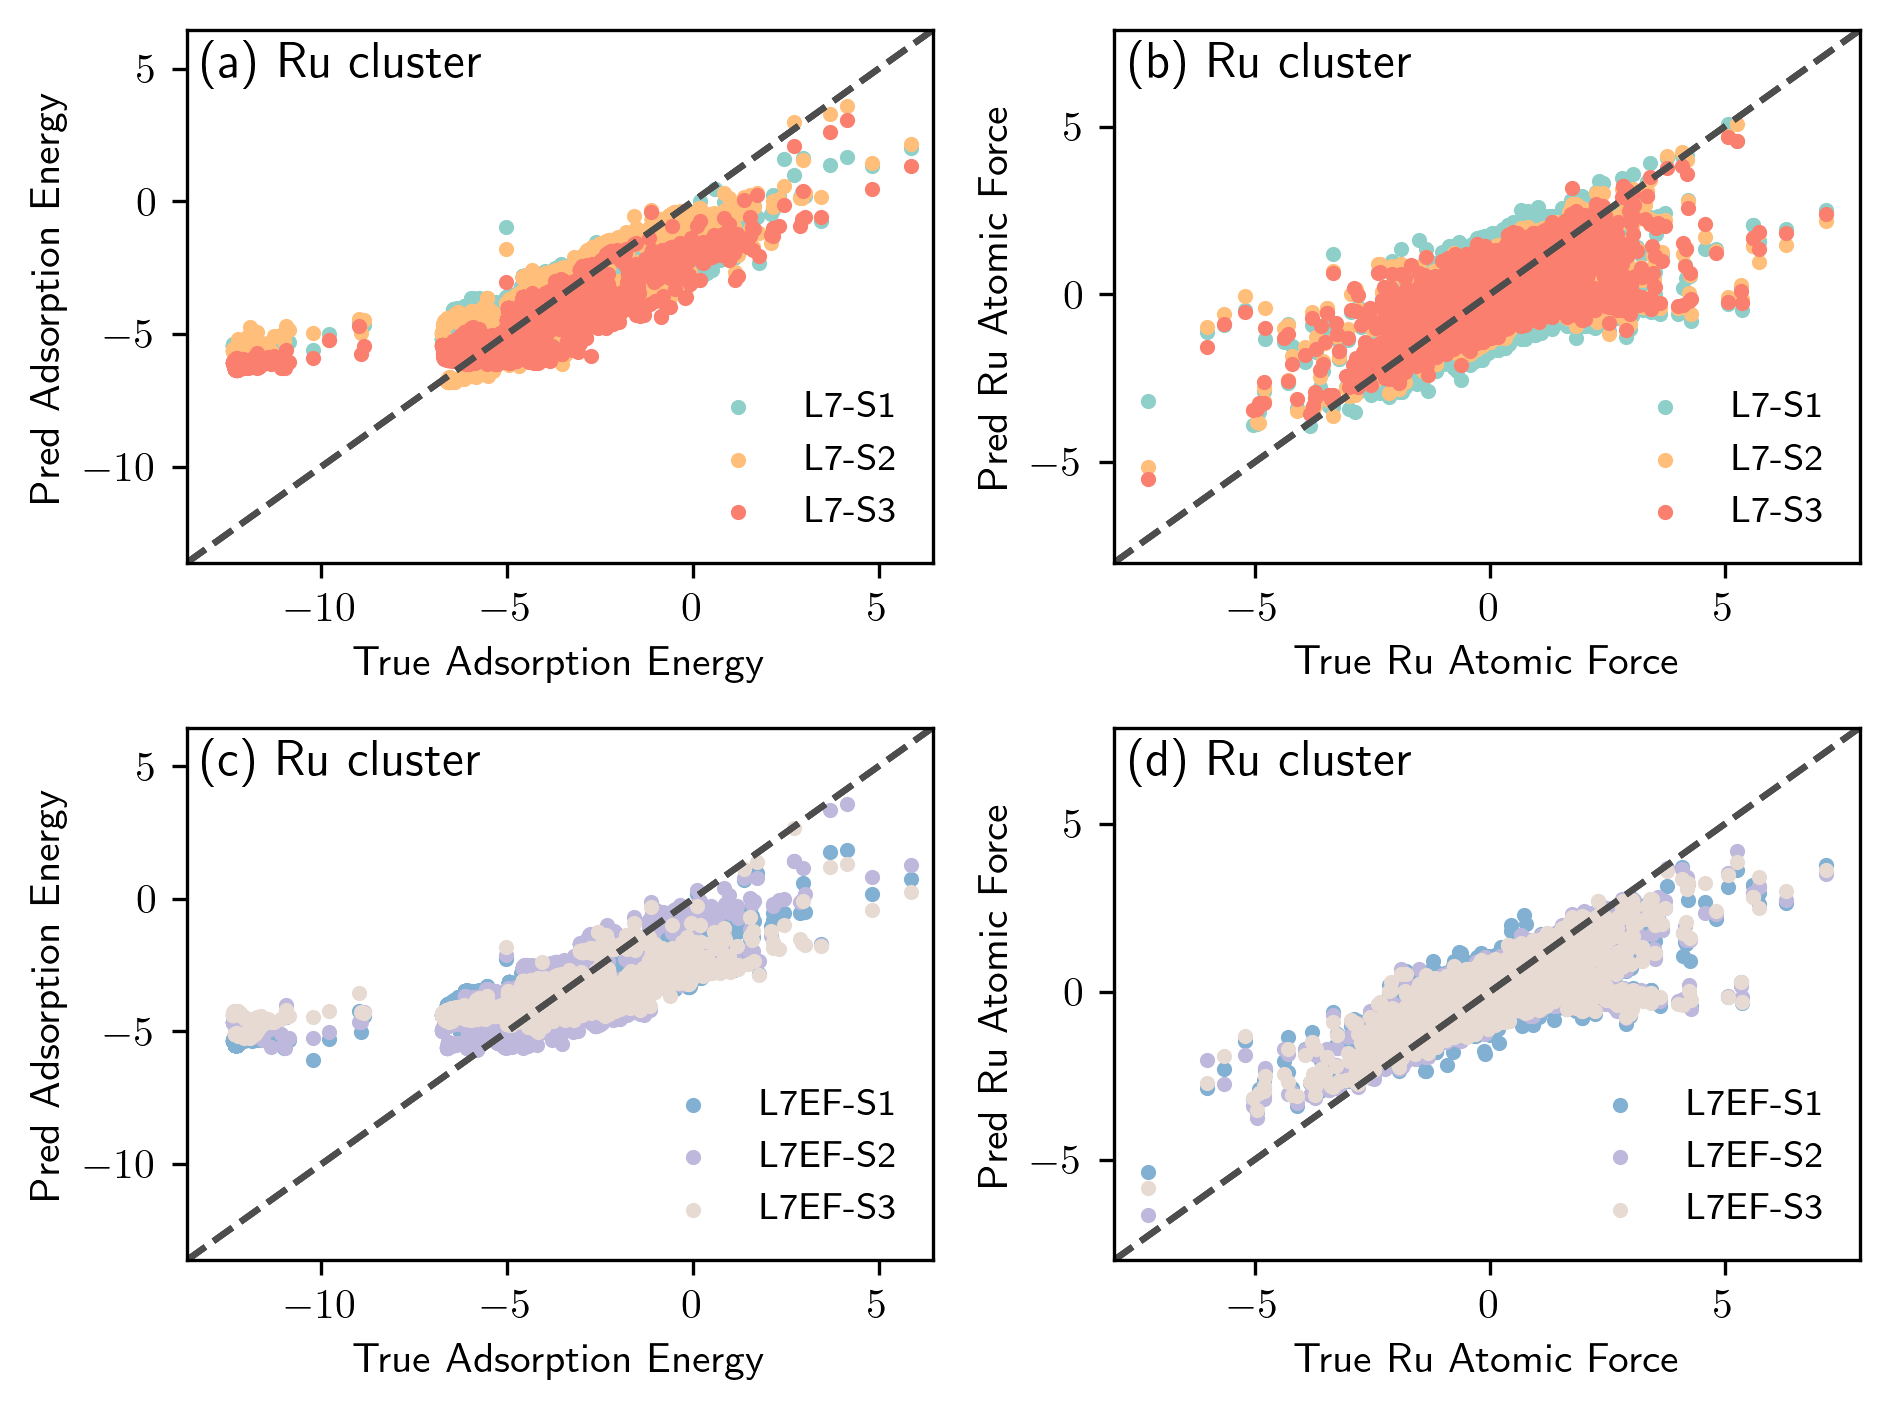

In [11]:
import numpy as np
Ru_prediction_list_energy = []
train_prediction_list = []
validate_prediction_list = []
test_prediction_list = []
names = ['eq_cluster_direct_until7', 'eq_cluster_further_until7', 'eq_cluster_mix_until7']
for address in names:
    Ru_prediction_list_energy.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Ru.npz', allow_pickle=True))
    train_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_train.npz', allow_pickle=True))
    validate_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_validate.npz', allow_pickle=True))
    test_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_test.npz', allow_pickle=True))

Ru_prediction_list_force = []
train_prediction_list = []
validate_prediction_list = []
test_prediction_list = []
names = ['eq_cluster_direct_until7_EFfix', 'eq_cluster_further_until7_EFfix', 'eq_cluster_mix_until7_EFfix']
for address in names:
    Ru_prediction_list_force.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Ru.npz', allow_pickle=True))
    train_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_train.npz', allow_pickle=True))
    validate_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_validate.npz', allow_pickle=True))
    test_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt_test.npz', allow_pickle=True))

siguations_energy = [r'L7-S1', r'L7-S2', r'L7-S3']
siguations_force = [r'L7EF-S1', r'L7EF-S2', r'L7EF-S3']

plt.rcParams['text.usetex'] = True
params= {"text.latex.preamble": r"\usepackage{amsmath}"}
plt.rcParams.update(params)
plot_metal_parity_compare_s(Ru_cluster, Ru_prediction_list_energy, Ru_prediction_list_force, siguations_energy, siguations_force, 44, True)

plt.tight_layout()
plt.show()